In [3]:
import numpy as np
import random
from random import randint
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader
import torchio as tio

# Load custom files
from dataset import ImageSubjectsDataset
from model import UNet
from visualization import plot_3d, plot_slice
from metrics import dice_coefficient
from preprocessing import dataset_transform, split_dataset
from torch.utils.tensorboard import SummaryWriter

seed = 128
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

import warnings
warnings.filterwarnings("ignore")

In [2]:
!tree -d -L 3

.
├── output
├── __pycache__
└── subset
    ├── subset_img
    │   ├── LUNG1-001
    │   ├── LUNG1-002
    │   ├── LUNG1-005
    │   ├── LUNG1-008
    │   ├── LUNG1-013
    │   ├── LUNG1-016
    │   ├── LUNG1-018
    │   ├── LUNG1-024
    │   ├── LUNG1-026
    │   └── LUNG1-028
    └── subset_masks
        ├── LUNG1-001
        ├── LUNG1-002
        ├── LUNG1-005
        ├── LUNG1-008
        ├── LUNG1-013
        ├── LUNG1-016
        ├── LUNG1-018
        ├── LUNG1-024
        ├── LUNG1-026
        └── LUNG1-028

25 directories


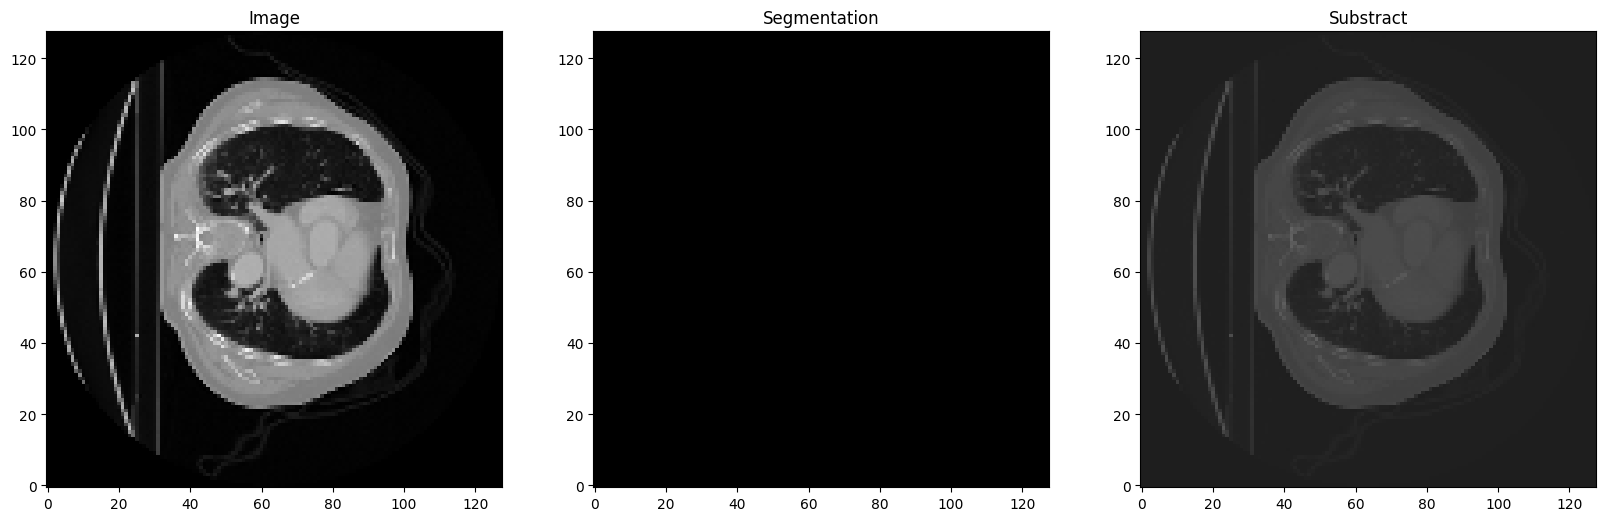

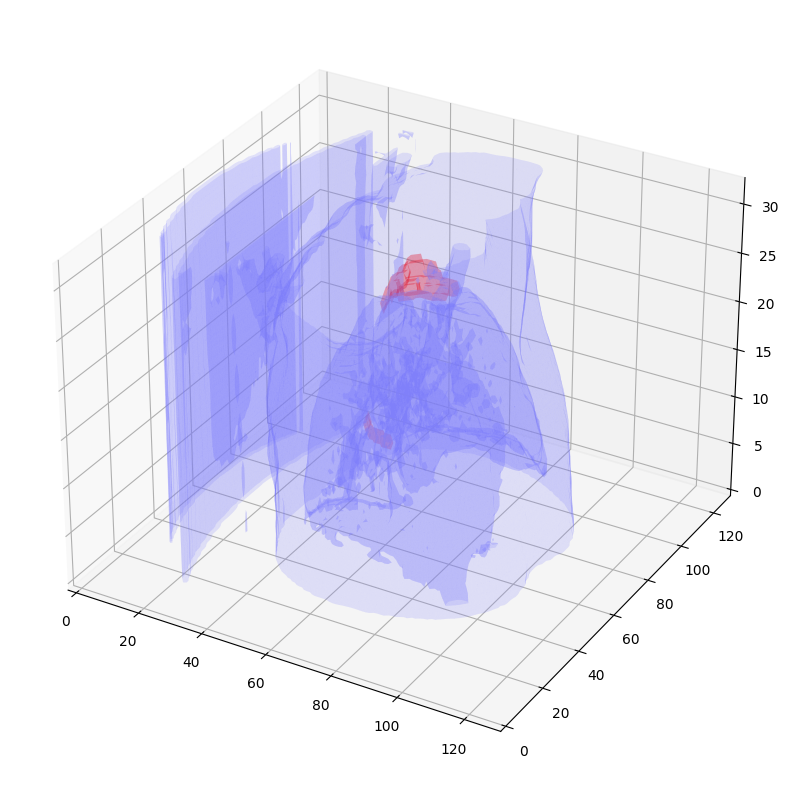

In [24]:
# Let's look at pictures
dataset = ImageSubjectsDataset(img_dir='./subset/subset_img/', mask_dir='./subset/subset_masks/', transform=dataset_transform())
batch_item = dataset.__getitem__(randint(0, dataset.__len__()-1))
plot_slice(batch_item)
plot_3d(batch_item)

In [28]:
# GPU is too weak for 5D tensors :( so, let's use CPU and take a coffee...
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
model = UNet(num_classes=1).to(device)
summary(model, (1, 128, 128, 32), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 64, 128, 128, 32]           1,792
       BatchNorm3d-2     [-1, 64, 128, 128, 32]             128
              ReLU-3     [-1, 64, 128, 128, 32]               0
            Conv3d-4     [-1, 64, 128, 128, 32]         110,656
       BatchNorm3d-5     [-1, 64, 128, 128, 32]             128
              ReLU-6     [-1, 64, 128, 128, 32]               0
         MaxPool3d-7       [-1, 64, 64, 64, 16]               0
            Conv3d-8      [-1, 128, 64, 64, 16]         221,312
       BatchNorm3d-9      [-1, 128, 64, 64, 16]             256
             ReLU-10      [-1, 128, 64, 64, 16]               0
           Conv3d-11      [-1, 128, 64, 64, 16]         442,496
      BatchNorm3d-12      [-1, 128, 64, 64, 16]             256
             ReLU-13      [-1, 128, 64, 64, 16]               0
        MaxPool3d-14       [-1, 128, 32

In [7]:
dataset = ImageSubjectsDataset(img_dir='./subset/subset_img/', mask_dir='./subset/subset_masks/')
train_dataset, valid_dataset = split_dataset(dataset, 
                                             test_size=0.2, 
                                             train_transform=dataset_transform(augumentation=True),
                                             test_transform=dataset_transform(),
                                             seed=seed,
                                             expand_ds=2,
                                            )
train_dataset.__len__(), valid_dataset.__len__()

(16, 2)

In [8]:
def model_run(model, data_loader, stage, device=torch.device('cpu'), clear_memory=False):
    '''
    Function of run the model with data loader generator
    '''
    loss_cum = 0
    dice_total = 0
    for data in data_loader:
        inputs = data['image']['data']
        labels = data['segmentation']['data']
        
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.type(torch.FloatTensor).to(device))
        loss_cum += loss.item()
        dice = dice_coefficient(outputs, labels)
        dice_total += dice
        
        if stage=='train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if clear_memory:
            del data
            gc.collect()
            torch.cuda.empty_cache()
        
    return loss_cum / len(data_loader), dice_total / len(data_loader)

In [9]:
%%time
train_dataloader = DataLoader(train_dataset, batch_size=1)
valid_dataloader = DataLoader(valid_dataset, batch_size=1)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.BCELoss()

last_dice = 0.
writer = SummaryWriter(log_dir='./output/')

for epoch in range(201): 
    
    for stage in ['train', 'eval']:
        # TRAIN
        if stage=='train':
            model.train()
            loss_train, dice_train = model_run(model, train_dataloader, stage, device)
        # EVALUATION
        elif stage=='eval':
            model.eval()
            with torch.no_grad():
                loss_valid, dice_valid = model_run(model, valid_dataloader, stage, device)
                
    if dice_valid > last_dice:
        last_dice = dice_valid
        torch.save(model.to('cpu').state_dict(), f'./output/best_model.pth')   
        
    writer.add_scalar('train_loss', loss_train, epoch)
    writer.add_scalar('valid_loss', loss_valid, epoch)
    writer.add_scalar('dice_coef_train', dice_train, epoch)
    writer.add_scalar('dice_coef_valid', dice_valid, epoch)

    if (epoch % 10 == 0):   
        print(f"Epoch: {epoch}, "
              f"train_loss: {loss_train:.3f}, "
              f"dice_train: {dice_train:.3f}, "
              f"valid_loss: {loss_valid:.3f}, "
              f"dice_valid: {dice_valid:.3f}"
             )
        
writer.close() 
print(f'Training is finished!')

Epoch: 0, train_loss: 0.324, dice_train: 0.005, valid_loss: 0.198, dice_valid: 0.004


KeyboardInterrupt: 

In [2]:
!tensorboard --logdir='./output/' --port 6006

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.11.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [3]:
device = 'cpu'
model = model = UNet(num_classes=1).to(device)
model.load_state_dict(torch.load(f'./output/best_model.pth', map_location=device))

<All keys matched successfully>

In [52]:
true_item = valid_dataset.__getitem__(1)
output = model(true_item['image']['data'].unsqueeze(0).to(device))
pred_item = tio.SubjectsDataset([tio.Subject(image = tio.ScalarImage(tensor=true_item['image']['data'].detach()),
                                             segmentation = tio.LabelMap(tensor=output.detach().squeeze(0)),
                                            )
                                ])
pred_item = pred_item.__getitem__(0)

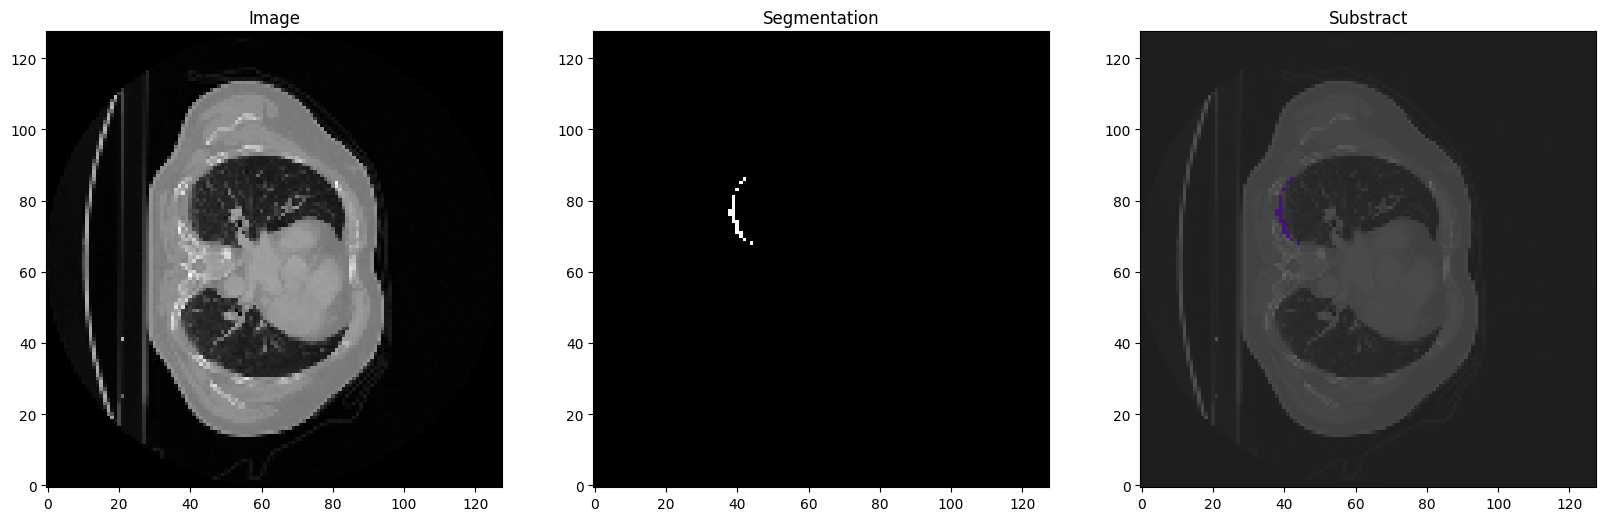

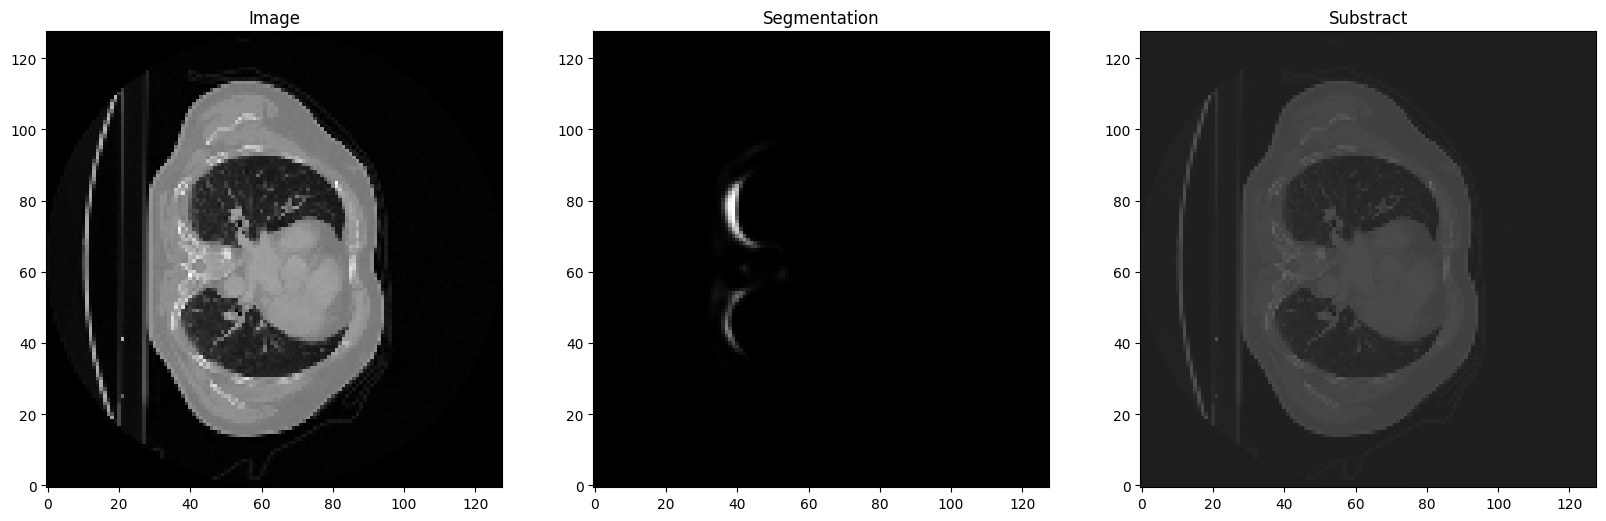

In [60]:
plot_slice(true_item, zslice=10)
plot_slice(pred_item, zslice=10)

## Summary
The model wasn't trained completely, so it's needed more epochs, but unfortumately there is some technical restrictions :(